## Notebook de simulation - Projet 4 - David Depouez

### 1. Importation et mise en place

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

from sklearn.utils import resample
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score

import datetime
from datetime import timedelta

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


On recupere le dataframe brut

In [2]:
Version = 2

path = "./data/cleaned/"

filename = 'Cleaned-V4-Raw.csv'

# for kagle use only

filename = "/kaggle/input/v4-raw/Cleaned-V4-Raw.csv"
path = ""

df = pd.read_csv(path + filename,low_memory=False)

In [3]:
df.shape
df.head()

,customer_id,order_id,order_purchase_timestamp,payment_value,customer_unique_id,review_score,word_number,delai,retard
0,9ef432eb6251297304e76186b10a928d,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,38.71,7c396fd4830fd04220f754e42b4e5bff,4.0,32.0,8,-8
1,b0830fb4747a6c6d20dea0b8c802d7ef,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,141.46,af07308b275d755c9edb36a90c618231,4.0,4.0,13,-6
2,41ce2a54c0b03bf3443c3d931a367089,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,179.12,3a653a41f6f9fc3d2a113cf8398680e8,5.0,0.0,9,-18
3,f88197465ea7920adcdbec7375364d82,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,72.20,7c142cf63193a1473d2e66489a9ae977,5.0,20.0,13,-13
4,8ab97904e6daea8866dbdbc4fb7aad2c,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,28.62,72632f0f9dd73dfee390c9b22eb56dd6,5.0,0.0,2,-10


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               99441 non-null  object 
 1   order_id                  99441 non-null  object 
 2   order_purchase_timestamp  99441 non-null  object 
 3   payment_value             99441 non-null  float64
 4   customer_unique_id        99441 non-null  object 
 5   review_score              99441 non-null  float64
 6   word_number               99441 non-null  float64
 7   delai                     99441 non-null  int64  
 8   retard                    99441 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 6.8+ MB


On convertit la date

In [5]:
df['order_purchase_timestamp'] = df['order_purchase_timestamp'].apply(pd.to_datetime)

In [6]:
def getCompCols(df,cols):
    ### Get complements colons of cols for a dataframe df ###
    ComplementCols =  [name for i,name in enumerate(df.columns) if name not in cols]
    return ComplementCols

Fonction de transformation du dataframe brut vers le dataframe mis en forme en fonction d'une date de fin

In [7]:
year = timedelta(days=365)
month = timedelta(days=30)

def extract(df_to_extract, end_date):
    
    print("Calling extract with date : ",end_date)
    maskHere = (df_to_extract['order_purchase_timestamp'] <= end_date)
    df_extract_reducted = df_to_extract.loc[maskHere == True,:]
    
    number = len(df_extract_reducted)
    print("Number of observation selected",number)
    
    # now group the dataframe by customer id and do compute the features values
    grouped = df_extract_reducted.groupby(by= ['customer_unique_id'] ,dropna=False)
    df_extract_reducted = grouped.agg({'order_id':'count','order_purchase_timestamp':'max','retard':'mean','delai':'mean',
                           'payment_value':'sum', 'review_score':'mean', 'word_number':'sum'})
    df_extract_reducted.rename(columns={'order_id':'Frequency','order_purchase_timestamp':'Recency','payment_value':'Monetary'},inplace=True)
    df_extract_reducted = df_extract_reducted.reset_index()
    
    # compute recency as number of days since the last command from today
    df_extract_reducted['Recency'] =  df_extract_reducted['Recency'].apply(lambda x: (pd.to_datetime('today') - x).days)
    
    df_extract_reducted.drop('customer_unique_id',axis=1,inplace=True)
    
    return df_extract_reducted

Fonctions pour les outliers

In [8]:
# Functions to handle outliers
def getQuantiles(dFrame,colName,lower=0.25,higher=0.75,isLog=False) :
    ### Get values corresponding to quartiles (defaults are for Q1 and Q3)###
    low,high = dFrame[colName].quantile([lower,higher])
    if isLog == True:
        print("For quantile {} val={:2.3} and for quantile {} val={:2.3}".format(lower,low,higher,high))
    return (low,high)

def computeTukeyMinMax(dFrame,colName,lower=0.25,higher=0.75, whis=1.5,isLog=False, minValue = 0.0) :
    ### Get min and max corresponding to Tukey's Law (default whis is 1.5)###
    Q1, Q3 = getQuantiles(dFrame,colName,lower=lower,higher=higher)
    IQR = Q3 - Q1
    
    vmin = Q1 - whis*IQR
    if vmin < minValue :
        vmin = minValue
    
    vmax = Q3 + whis*IQR
    if isLog == True:
        print("Q1 {:2.3} Q3 {:2.3} IQR {:2.3} vmin {:2.3} vmax {:2.3}".format(Q1,Q3,IQR,vmin,vmax))
    return (vmin,vmax)

def displayOutliers(dFrame,colName,isDump=False,isLog=False, minValue = 0.0) :
    ### Display outliers and according boxplot based on Tukey's law ###
    vmin, vmax = computeTukeyMinMax(dFrame,colName,minValue)
    mask = (dFrame[colName] > vmax) | (dFrame[colName] < vmin)
    nbOutliers = len(dFrame.loc[mask == True , :])
    if nbOutliers != 0 and isDump == True:
        display(dFrame.loc[mask == True ,[colName]].sort_values(by=colName,ascending=False))
    dFrame.boxplot(column = colName, grid = False)
    if isLog == True:
        print("{} Outliers, vmin {:2.3} vmax {:2.3}".format(nbOutliers,vmin,vmax))
    return (vmin,vmax,nbOutliers)

#dFrame[colName].clip(lower=low,upper=up,inplace=True)

In [9]:
df['order_purchase_timestamp'].min(), df['order_purchase_timestamp'].max()

(Timestamp('2016-09-04 21:15:19'), Timestamp('2018-10-17 17:30:18'))

Colonnes à traiter pour outliers et instantiation du scaler

In [10]:
keep = ['Monetary','retard', 'word_number','delai']

scaler = StandardScaler()

instantiation de kmeans

In [11]:
#kmeans = KMeans(n_clusters=3,init='k-means++',n_init=10)
kmeans = KMeans(n_clusters=3,init='k-means++',n_init=10,random_state=42)

Date de debut et de fin de la simulation (à 1 an de la fin du dataset)

In [13]:
endDate = df['order_purchase_timestamp'].max()
beginDate = endDate - 1*year
print("Begin {} End {}".format(beginDate,endDate))

Begin 2017-10-17 17:30:18 End 2018-10-17 17:30:18


### 2. Etude sur des intervalles de 30 jours

Creation des dates d'observation

In [14]:
period = 30 # in days
period = period*timedelta(days=1)

dateList = []

counter = 0
date = beginDate
while date <= endDate:
    dateList.append(date)
    #print(date)
    counter = counter + 1
    date = beginDate+counter*period
    
index = [i.date() for i in dateList]
print("Begin {} End {} Nb {}".format(index[0],index[-1],len(index)))

Begin 2017-10-17 End 2018-10-12 Nb 13


Pour chaque date donnée on extrait le dataframe correspondant puis on traite les outliers, on scale et on compare la prediction des data avec le fit des datas et on calcul score ARI

In [15]:
ariScoreList = []
for i,date in  enumerate(dateList):
    print(i,date)
    dfReduct = extract(df, date)
    for j in keep:
        #print(j)
        valMin, valMax = computeTukeyMinMax(dfReduct,j,isLog=False,higher=0.85,lower=0.15,minValue=dfReduct[j].min())
        #print(valMin, valMax)
        dfReduct[j].clip(lower=valMin,upper=valMax,inplace=True)

    XFull = dfReduct.to_numpy()

    if i == 0:
        X_init = scaler.fit_transform(XFull)
        C_init = kmeans.fit_predict(X_init)
        X_new = scaler.transform(XFull,copy=True)
        C_new = kmeans.predict(X_new)
    else:
        X_init = scaler.transform(XFull,copy=True)
        C_init = kmeans.predict(X_init)
        X_new = scaler.fit_transform(XFull)
        C_new = kmeans.fit_predict(X_new)

    ariScore = adjusted_rand_score(C_init, C_new)
    print("Ari Score for i={} is {}".format(i,ariScore) )
    ariScoreList.append(ariScore)

0 2017-10-17 17:30:18
Calling extract with date :  2017-10-17 17:30:18
Number of observation selected 30096
Ari Score for i=0 is 1.0
1 2017-11-16 17:30:18
Calling extract with date :  2017-11-16 17:30:18
Number of observation selected 34791
Ari Score for i=1 is 0.9876638080127371
2 2017-12-16 17:30:18
Calling extract with date :  2017-12-16 17:30:18
Number of observation selected 43393
Ari Score for i=2 is 0.9327957271890326
3 2018-01-15 17:30:18
Calling extract with date :  2018-01-15 17:30:18
Number of observation selected 48811
Ari Score for i=3 is 0.7673509588665929
4 2018-02-14 17:30:18
Calling extract with date :  2018-02-14 17:30:18
Number of observation selected 55747
Ari Score for i=4 is 0.7902865134614272
5 2018-03-16 17:30:18
Calling extract with date :  2018-03-16 17:30:18
Number of observation selected 63196
Ari Score for i=5 is 0.930529277190201
6 2018-04-15 17:30:18
Calling extract with date :  2018-04-15 17:30:18
Number of observation selected 69875
Ari Score for i=6 is

Representation graphique des résultats

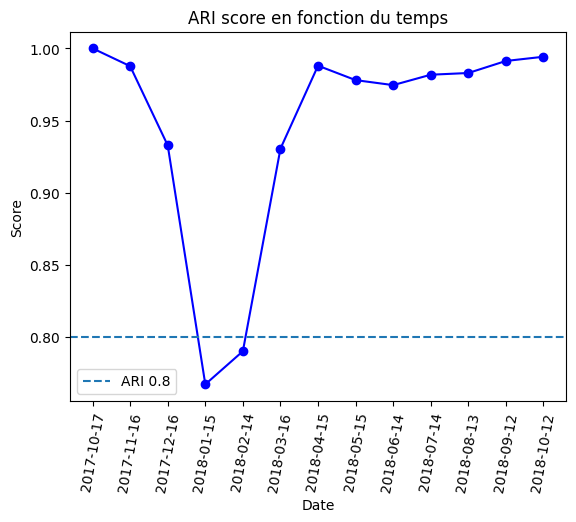

In [16]:

plt.plot(index, ariScoreList,c='blue',marker='o')
#axes = plt.gca()
plt.axhline(y=0.8,linestyle='--',label='ARI 0.8')
plt.xlabel("Date")
#plt.xlim([dateList[0], dateList[2]])
#axes.xaxis.set_ticks(range(3))
#axes.set_xlim(0, 6)
plt.xticks(index)
plt.xticks(rotation = 80)
plt.ylabel("Score")
plt.title("ARI score en fonction du temps")
plt.legend()
plt.show(block=False)

On recommence le meme process avec des intervalles de 15 jours plutot que 30 jours

### 3. Etude sur des intervalles de 15 jours

In [17]:
period = 15 # in days
period = period*timedelta(days=1)

dateList = []

counter = 0
date = beginDate
while date <= endDate:
    dateList.append(date)
    #print(date)
    counter = counter + 1
    date = beginDate+counter*period
    
index = [i.date() for i in dateList]
print("Begin {} End {} Nb {}".format(index[0],index[-1],len(index)))

Begin 2017-10-17 End 2018-10-12 Nb 25


In [18]:
ariScoreList = []
for i,date in  enumerate(dateList):
    print(i,date)
    dfReduct = extract(df, date)
    for j in keep:
        #print(j)
        valMin, valMax = computeTukeyMinMax(dfReduct,j,isLog=False,higher=0.85,lower=0.15,minValue=dfReduct[j].min())
        #print(valMin, valMax)
        dfReduct[j].clip(lower=valMin,upper=valMax,inplace=True)

    XFull = dfReduct.to_numpy()

    if i == 0:
        X_init = scaler.fit_transform(XFull)
        C_init = kmeans.fit_predict(X_init)
        X_new = scaler.transform(XFull,copy=True)
        C_new = kmeans.predict(X_new)
    else:
        X_init = scaler.transform(XFull,copy=True)
        C_init = kmeans.predict(X_init)
        X_new = scaler.fit_transform(XFull)
        C_new = kmeans.fit_predict(X_new)

    ariScore = adjusted_rand_score(C_init, C_new)
    print("Ari Score for i={} is {}".format(i,ariScore) )
    ariScoreList.append(ariScore)

0 2017-10-17 17:30:18
Calling extract with date :  2017-10-17 17:30:18
Number of observation selected 30096
Ari Score for i=0 is 1.0
1 2017-11-01 17:30:18
Calling extract with date :  2017-11-01 17:30:18
Number of observation selected 32289
Ari Score for i=1 is 0.987538913177524
2 2017-11-16 17:30:18
Calling extract with date :  2017-11-16 17:30:18
Number of observation selected 34791
Ari Score for i=2 is 0.989589894483919
3 2017-12-01 17:30:18
Calling extract with date :  2017-12-01 17:30:18
Number of observation selected 39962
Ari Score for i=3 is 0.944041176831237
4 2017-12-16 17:30:18
Calling extract with date :  2017-12-16 17:30:18
Number of observation selected 43393
Ari Score for i=4 is 0.9845103207104301
5 2017-12-31 17:30:18
Calling extract with date :  2017-12-31 17:30:18
Number of observation selected 45412
Ari Score for i=5 is 0.9915002076143274
6 2018-01-15 17:30:18
Calling extract with date :  2018-01-15 17:30:18
Number of observation selected 48811
Ari Score for i=6 is 0

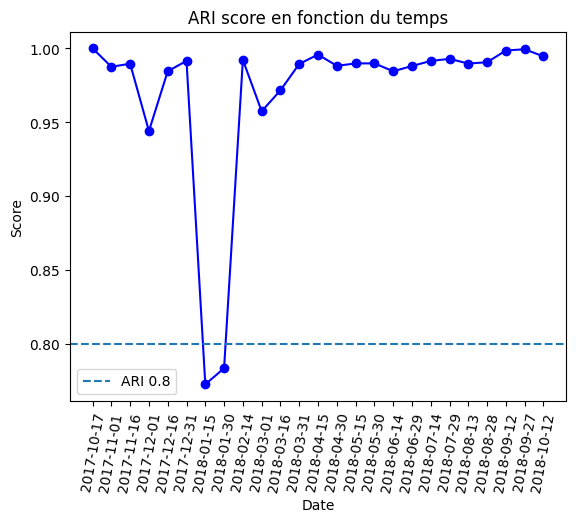

In [19]:

plt.plot(index, ariScoreList,c='blue',marker='o')
#axes = plt.gca()
plt.axhline(y=0.8,linestyle='--',label='ARI 0.8')
plt.xlabel("Date")
#plt.xlim([dateList[0], dateList[2]])
#axes.xaxis.set_ticks(range(3))
#axes.set_xlim(0, 6)
plt.xticks(index)
plt.xticks(rotation = 80)
plt.ylabel("Score")
plt.title("ARI score en fonction du temps")
plt.legend()
plt.show(block=False)